In [1]:
import pandas as pd
from nebulagraph_lite import nebulagraph_let as ng_let
import os, math

# Data loading


In [2]:
# load NebulaGraph JupyterNotebook extension
!udocker pull vesoft/nebula-metad:v3
!udocker create --name=nebula-metad vesoft/nebula-metad:v3
!udocker setup --execmode=F1 nebula-metad
!udocker pull vesoft/nebula-graphd:v3
!udocker create --name=nebula-graphd vesoft/nebula-graphd:v3
!udocker setup --execmode=F1 nebula-graphd
!udocker pull vesoft/nebula-storaged:v3
!udocker create --name=nebula-storaged vesoft/nebula-storaged:v3
!udocker setup --execmode=F1 nebula-storaged

n = ng_let(in_container=True)
n.start() # This takes around 5 mins


Info: downloading layer sha256:20717c72714566f0a51c0f26f7237ae23515d730d9ffe7b8c34bb0f448d23beb
Info: downloading layer sha256:f73b0b86b2168fee37455b76bbb9a850d41ad48dda1544fa5a4c8fb933bfa006
Info: downloading layer sha256:4f4fb700ef54461cfa02571ae0db9a0dc1e0cdb5577484a6d75e68dc38e8acc1
Info: downloading layer sha256:3567ff3965abe5d66952e4a8be22af4c6e9a95d2ac02ada22ac6c0b0be37a2c1
Info: downloading layer sha256:5beb905c3081ead3dd9f9a60673fd722da67b135bc558bc71b92d69ec12ae999
Info: downloading layer sha256:2d473b07cdd5f0912cd6f1a703352c82b512407db6b05b43f2553732b55df3bc
32b1542c-05f1-3225-91e1-211da73cae13
Info: downloading layer sha256:1ac1fd25afe5d455d2582e90b07d4eedabf5eae8e66b6508893bb030f7db5157
Info: downloading layer sha256:ca0b24da507dc453e8724ea7a219ee899c2f3020d2828e982d0e36bf546ba2f4
Info: downloading layer sha256:4f4fb700ef54461cfa02571ae0db9a0dc1e0cdb5577484a6d75e68dc38e8acc1
Info: downloading layer sha256:b3d21254eb5aefb20a7ac54f1000092a19fd6a4a874319ccae2ccbed0ee5af6e
Inf

In [4]:
%load_ext ngql

In [4]:
%reload_ext ngql

In [5]:
%ngql --address 127.0.0.1 --port 9669 --user root --password nebula


[OK] Connection Pool Created


,Name
0,basketballplayer


In [7]:
# Create a new Graph space (graph) for the PrimeKG
%ngql CREATE SPACE IF NOT EXISTS PrimeKG (vid_type = INT64);
%ngql USE PrimeKG;

""


# Create the graph from NebulaGraph directly

In [7]:
#primekg = pd.read_csv("~/scratch-llm/data/PrimeKG_data/raw_data/kg.csv", low_memory=False)
nodes = pd.read_csv("~/scratch-llm/data/PrimeKG_data/raw_data/nodes.csv",
    low_memory=False,
    sep=',',
    quotechar='"',  
    escapechar='\\', 
)

edges = pd.read_csv("~/scratch-llm/data/PrimeKG_data/raw_data/edges.csv")

## Nodes

In [ ]:
print(nodes['node_type'].unique()) #types of nodes

In [ ]:
# save the data for each 'node_type' in a separate file
for node_type in nodes['node_type'].unique():
    sanitized_node_type = node_type.replace('/', '_')
    output_path = os.path.join('~/scratch-llm/data/PrimeKG_data/sub_data/', 'node_'+ sanitized_node_type + '.csv')
    nodes[nodes['node_type'] == node_type].to_csv(output_path, index=False)

In [ ]:
# Create Tags (node_type) for each node in the PrimeKG
%ngql CREATE TAG IF NOT EXISTS anatomy(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS gene_protein(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS drug(node_name string, node_source string, node_id string, description string, half_life string, indication string, mechanism_of_action string, protein_binding string, pharmacodynamics string, state string, atc_1 string, atc_2 string, atc_3 string, atc_4 string, category string, group string, pathway string, molecular_weight string, tpsa string, clogp string);
%ngql CREATE TAG IF NOT EXISTS disease(node_name string, node_source string, mondo_id int, mondo_name string, group_id_bert string, group_name_bert string, mondo_definition string, umls_description string, orphanet_definition string, orphanet_prevalence string, orphanet_epidemiology string, orphanet_clinical_description string, orphanet_management_and_treatment string, mayo_symptoms string, mayo_causes string, mayo_risk_factors string, mayo_complications string, mayo_prevention string, mayo_see_doc string);
%ngql CREATE TAG IF NOT EXISTS pathway(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS biological_process(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS effect_phenotype(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS molecular_function(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS cellular_component(node_name string, node_source string, node_id string);
%ngql CREATE TAG IF NOT EXISTS exposure(node_name string, node_source string, node_id string);

In [ ]:
# Load each node source data into the corresponding Tag (working fine)
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_gene_protein.csv --tag gene_protein --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_biological_process.csv --tag biological_process --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_effect_phenotype.csv --tag effect_phenotype --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_molecular_function.csv --tag molecular_function --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_cellular_component.csv --tag cellular_component --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_pathway.csv --tag pathway --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_exposure.csv --tag exposure --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_anatomy.csv --tag anatomy --header --space PrimeKG --vid 0 --props 2:node_id,3:node_name,4:node_source


### Extra information for nodes 'drug' and 'disease'

In [ ]:
# disease and drug feature files are available as .tab format so they need to be converted to .csv
# many formatting issues on both files that had to be correcteed manually before merging with the 'node_' dataset
disease_tab = "~/scratch-llm/data/PrimeKG_data/raw_data/disease_features.tab"
drug_tab = "~/scratch-llm/data/PrimeKG_data/raw_data/drug_features.tab"

df = pd.read_csv(disease_tab, delimiter='\t')
disease_csv = "~/scratch-llm/data/PrimeKG_data/sub_data/disease_features.csv"
df.to_csv(disease_csv, index=False)


df = pd.read_csv(drug_tab, delimiter='\t')
drug_csv = "~/scratch-llm/data/PrimeKG_data/sub_data/drug_features.csv"
df.to_csv(drug_csv, index=False) 

In [10]:
# merge extra drug and disease information 
node_drug = pd.read_csv("~/scratch-llm/data/PrimeKG_data/sub_data/node_drug.csv")
features_drug = pd.read_csv("~/scratch-llm/data/PrimeKG_data/sub_data/drug_features.csv")
node_disease = pd.read_csv("~/scratch-llm/data/PrimeKG_data/sub_data/node_disease.csv")
features_disease = pd.read_csv("~/scratch-llm/data/PrimeKG_data/sub_data/disease_features.csv")


In [11]:
# the disease_features has multiple rows with the same 'node_index' so we need to merge them
def merge_column_values(column):
    # Check if all values in the column can be converted to float
    try:
        numeric_column = pd.to_numeric(column, errors='coerce')
        if numeric_column.notna().all():  # If all are numbers, return unique values
            return '; '.join(map(str, sorted(set(numeric_column))))  # Keep the first numeric value (assuming they're the same)
    except Exception:
        pass
    
    # For strings, concatenate unique, non-empty values
    return '; '.join(filter(lambda x: pd.notna(x) and str(x).strip() != '', set(column)))

merged_features_disease = features_disease.groupby('node_index', as_index=False).agg(merge_column_values)

In [ ]:
# Merge the dataframes on 'node_index' and save to csv
merged_df = pd.merge(node_drug, features_drug, on='node_index')
merged_df.to_csv("~/scratch-llm/data/PrimeKG_data/sub_data/node_merged_drug.csv", index=False)

merged_df = pd.merge(node_disease, merged_features_disease, on='node_index')
# merged_df.fillna("", inplace=True) # in case included 'extra' diseases that are only present in features_disease
merged_df.to_csv("~/scratch-llm/data/PrimeKG_data/sub_data/node_merged_disease.csv", index=False)

In [ ]:
#Load the extended drug and disease data into the corresponding Tags
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_merged_disease.csv --tag disease --header --space PrimeKG --vid 0 --props 3:node_name,4:node_source,5:mondo_id,6:mondo_name,7:group_id_bert,8:group_name_bert,9:mondo_definition,10:umls_description,11:orphanet_definition,12:orphanet_prevalence,13:orphanet_epidemiology,14:orphanet_clinical_description,15:orphanet_management_and_treatment,16:mayo_symptoms,17:mayo_causes,18:mayo_risk_factors,19:mayo_complications,20:mayo_prevention,21:mayo_see_doc
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/node_merged_drug.csv --tag drug --header --space PrimeKG --batch 100 --vid 0 --props 2:node_id,3:node_name,4:node_source,5:description,6:half_life,7:indication,8:mechanism_of_action,9:protein_binding,10:pharmacodynamics,11:state,12:atc_1,13:atc_2,14:atc_3,15:atc_4,16:category,17:group,18:pathway,19:molecular_weight,20:tpsa,21:clogp


## Edges

In [ ]:
print(edges['relation'].unique()) # types of edges

In [8]:
# save the data for each 'relation' (edge type) in a separate file
for relation in edges['relation'].unique():
    sanitized_relation = relation.replace('-', '_')
    sanitized_relation = sanitized_relation.replace('\t', '_')
    output_path = os.path.join('~/scratch-llm/data/PrimeKG_data/sub_data/', 'edge_'+ sanitized_relation + '.csv')
    edges[edges['relation'] == relation].to_csv(output_path, index=False)

In [ ]:
%ngql CREATE EDGE IF NOT EXISTS protein_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS drug_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS contraindication(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS indication(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS off_label_use(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS drug_drug(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS phenotype_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS phenotype_phenotype(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS disease_phenotype_negative(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS disease_phenotype_positive(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS disease_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS disease_disease(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS drug_effect(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS bioprocess_bioprocess(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS molfunc_molfunc(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS cellcomp_cellcomp(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS molfunc_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS cellcomp_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS bioprocess_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_disease(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_exposure(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_bioprocess(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_molfunc(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS exposure_cellcomp(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS pathway_pathway(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS pathway_protein(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS anatomy_anatomy(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS anatomy_protein_present(display_relation string);
%ngql CREATE EDGE IF NOT EXISTS anatomy_protein_absent(display_relation string);

In [ ]:
# for each edge type, load the data accordingly, this takes like 20mins from new
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_protein_protein.csv --space PrimeKG --header --edge protein_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_drug_protein.csv --space PrimeKG --header --edge drug_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_contraindication.csv --space PrimeKG --header --edge contraindication --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_indication.csv --space PrimeKG --header --edge indication --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_off_label_use.csv --space PrimeKG --header --edge off_label_use --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_drug_drug.csv --space PrimeKG --header --edge drug_drug --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_phenotype_protein.csv --space PrimeKG --header --edge phenotype_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_phenotype_phenotype.csv --space PrimeKG --header --edge phenotype_phenotype --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_disease_phenotype_negative.csv --space PrimeKG --header --edge disease_phenotype_negative --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_disease_phenotype_positive.csv --space PrimeKG --header --edge disease_phenotype_positive --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_disease_protein.csv --space PrimeKG --header --edge disease_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_disease_disease.csv --space PrimeKG --header --edge disease_disease --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_drug_effect.csv --space PrimeKG --header --edge drug_effect --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_bioprocess_bioprocess.csv --space PrimeKG --header --edge bioprocess_bioprocess --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_molfunc_molfunc.csv --space PrimeKG --header --edge molfunc_molfunc --src 2 --dst 3 --props 1:display_relation


In [ ]:
# load the edge data in two batches
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_cellcomp_cellcomp.csv --space PrimeKG --header --edge cellcomp_cellcomp --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_molfunc_protein.csv --space PrimeKG --header --edge molfunc_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_cellcomp_protein.csv --space PrimeKG --header --edge cellcomp_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_bioprocess_protein.csv --space PrimeKG --header --edge bioprocess_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_protein.csv --space PrimeKG --header --edge exposure_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_disease.csv --space PrimeKG --header --edge exposure_disease --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_exposure.csv --space PrimeKG --header --edge exposure_exposure --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_bioprocess.csv --space PrimeKG --header --edge exposure_bioprocess --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_molfunc.csv --space PrimeKG --header --edge exposure_molfunc --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_exposure_cellcomp.csv --space PrimeKG --header --edge exposure_cellcomp --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_pathway_pathway.csv --space PrimeKG --header --edge pathway_pathway --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_pathway_protein.csv --space PrimeKG --header --edge pathway_protein --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_anatomy_anatomy.csv --space PrimeKG --header --edge anatomy_anatomy --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_anatomy_protein_present.csv --space PrimeKG --batch 500 --header --edge anatomy_protein_present --src 2 --dst 3 --props 1:display_relation
%ng_load --source ~/scratch-llm/data/PrimeKG_data/sub_data/edge_anatomy_protein_absent.csv --space PrimeKG --header --edge anatomy_protein_absent --src 2 --dst 3 --props 1:display_relation


## Checks

In [ ]:
#small check-up, with extra drug and disease information for nodes
%ngql GET SUBGRAPH WITH PROP 1 STEPS FROM 14045 OUT drug_protein YIELD VERTICES AS nodes, EDGES AS relationships;

# Load directly to NebulaPropertyGraphStore

In [14]:
from llama_index.core.schema import NodeRelationship, TextNode, IndexNode, RelatedNodeInfo
from llama_index.graph_stores.nebula import NebulaPropertyGraphStore
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from transformers import AutoTokenizer
from llama_index.core import (
    StorageContext,
    PropertyGraphIndex,
    Settings
)
import torch


define files to use:

In [6]:
data_dir = '~/scratch-llm/data/PrimeKG_data/sub_data/'

# List of node types and their corresponding CSV files
node_files = {
    'node_gene_protein.csv',
    'node_merged_drug.csv', # manually corrected and generated from "extra information section"
    'node_effect_phenotype.csv',
    'node_merged_disease.csv', # manually corrected and generated from "extra information section"
    'node_biological_process.csv',
    'node_molecular_function.csv',
    'node_cellular_component.csv',
    'node_exposure.csv',
    'node_pathway.csv',
    'node_anatomy.csv'
}

edge_files ={
    'edge_protein_protein.csv',
    'edge_drug_protein.csv',
    'edge_contraindication.csv',
    'edge_indication.csv',
    'edge_off_label_use.csv',
    'edge_drug_drug.csv',
    'edge_phenotype_protein.csv',
    'edge_phenotype_phenotype.csv',
    'edge_disease_phenotype_negative.csv',
    'edge_disease_phenotype_positive.csv',
    'edge_disease_protein.csv',
    'edge_disease_disease.csv',
    'edge_drug_effect.csv',
    'edge_bioprocess_bioprocess.csv',
    'edge_molfunc_molfunc.csv',
    'edge_cellcomp_cellcomp.csv',
    'edge_molfunc_protein.csv',
    'edge_cellcomp_protein.csv',
    'edge_bioprocess_protein.csv',
    'edge_exposure_protein.csv',
    'edge_exposure_disease.csv',
    'edge_exposure_exposure.csv',
    'edge_exposure_bioprocess.csv',
    'edge_exposure_molfunc.csv',
    'edge_exposure_cellcomp.csv',
    'edge_pathway_pathway.csv',
    'edge_pathway_protein.csv',
    'edge_anatomy_anatomy.csv',
    'edge_anatomy_protein_present.csv',
    'edge_anatomy_protein_absent.csv'
}

## Nodes

In [5]:
# create TextNodes
def create_text_nodes(file_path):
    df = pd.read_csv(file_path)
    text_nodes = []
    for _, row in df.iterrows():
        id = row['node_index']
        if len(row) > 5: # longer text info (drug/disease)
            metadata_columns = ['node_index', 'node_id', 'node_type', 'node_name', 
                            'node_source', 'mondo_id', 'mondo_name', 'group_id_bert', 
                            'group_name_bert', 'orphanet_prevalence']
            
            text_columns = ['mondo_definition', 'umls_description', 'orphanet_definition', 
                        'orphanet_clinical_description', 'orphanet_management_and_treatment','orphanet_epidemiology', 
                        'mayo_symptoms', 'mayo_causes', 'mayo_risk_factors', 'mayo_complications',
                        'mayo_prevention', 'mayo_see_doc','description', 'indication', 'mechanism_of_action',
                        'half_life', 'protein_binding', 'pharmacodynamics', 'state', 'atc_1', 'atc_2', 'atc_3', 
                        'atc_4', 'category', 'group', 'pathway', 'molecular_weight', 'tpsa', 'clogp'] 
            available_metadata_columns = [col for col in metadata_columns if col in df.columns]
            available_text_columns = [col for col in text_columns if col in df.columns] 

            # Extract metadata, not including empty entries     
            metadata = {
                col: row[col] for col in available_metadata_columns
                if col in row and not (isinstance(row[col], float) and math.isnan(row[col]))
            }
            metadata = {k: str(v) for k, v in metadata.items()} #ensure entries are strings

            # Extract and concatenate text values, not including empty entries
            text_entries = [str(row[col]) for col in available_text_columns if pd.notna(row[col])]
            text = "\n".join(text_entries)            

            text_node = TextNode(id_= str(id), text=text, metadata=metadata)
            text_nodes.append(text_node)

        else: # no text data, all other files
            metadata = row.to_dict()
            metadata = {k: str(v) for k, v in metadata.items()} #ensure entries are strings
            text_node = TextNode(id_= str(id), metadata=metadata)
            text_nodes.append(text_node)

    return text_nodes


In [9]:
# generate all nodes from the node files
all_nodes = []
for file in node_files:
    nodes = create_text_nodes(data_dir+file)
    all_nodes.extend(nodes)


## Edges

In [10]:
# create all edges
from tqdm.notebook import tqdm

def create_all_edges(file_path, all_nodes):
    node_dict = {node.id_: node for node in all_nodes} #speed up search
    df = pd.read_csv(os.path.join(file_path))

    for _, row in tqdm(df.iterrows(), total=len(df), leave=False, desc=f"Processing {file_path}"):
        x_index = str(row['x_index'])
        y_index = str(row['y_index'])
        
        if x_index in node_dict:
            origin_node = node_dict[x_index]
            if NodeRelationship.CHILD not in origin_node.relationships:
                origin_node.relationships[NodeRelationship.CHILD] = []
           
            metadata = row.drop(['x_index', 'y_index']).to_dict()
            new_relationship = RelatedNodeInfo(node_id=y_index, metadata=metadata)
            origin_node.relationships[NodeRelationship.CHILD].append(new_relationship)


In [ ]:
# all relationships for all nodes, takes around 120 mins
for file in tqdm(edge_files, desc='Procesing edge files'):
    create_all_edges(data_dir+file, all_nodes)

Procesing edge files:   0%|          | 0/30 [00:00<?, ?it/s]

Processing ~/scratch-llm/data/PrimeKG_data/sub_data/edge_disease_phenotype_positive.csv:   0%|          | 0/30…

save/load nodes-relationships to pickle

In [51]:
# save `all_nodes` with pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_nodes.pkl'), 'wb') as f:
    pickle.dump(all_nodes, f)

In [6]:
# load from pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/all_nodes.pkl'), 'rb') as f:
    nodes = pickle.load(f)
    

In [8]:
import json

# Convert nodes to a list of dictionaries
nodes_dicts = []
for node in nodes:
	node_dict = node.__dict__.copy()
	node_dict['relationships'] = json.dumps(node_dict['relationships'], default=str)  # Convert relationships to JSON string
	nodes_dicts.append(node_dict)

# Save to Parquet
df = pd.DataFrame(nodes_dicts)
df.to_parquet('~/scratch-llm/storage/all_nodes.parquet', index=False)

In [27]:
# find index of id_ = 35769
for i, node in enumerate(nodes):
    if node.id_ == '35769':
        for rel in node.relationships[NodeRelationship.CHILD]:
            print(rel)


node_id='36017' node_type=None metadata={'relation': 'disease_disease', 'display_relation': 'parent-child'} hash=None
node_id='35525' node_type=None metadata={'relation': 'disease_disease', 'display_relation': 'parent-child'} hash=None
node_id='36178' node_type=None metadata={'relation': 'disease_disease', 'display_relation': 'parent-child'} hash=None
node_id='36923' node_type=None metadata={'relation': 'disease_disease', 'display_relation': 'parent-child'} hash=None
node_id='96068' node_type=None metadata={'relation': 'disease_disease', 'display_relation': 'parent-child'} hash=None
node_id='35585' node_type=None metadata={'relation': 'disease_disease', 'display_relation': 'parent-child'} hash=None
node_id='97172' node_type=None metadata={'relation': 'disease_disease', 'display_relation': 'parent-child'} hash=None
node_id='84007' node_type=None metadata={'relation': 'disease_disease', 'display_relation': 'parent-child'} hash=None
node_id='38898' node_type=None metadata={'relation': 'di

In [29]:
# find the index in "nodes" of node.id_ = 35769
for i, node in enumerate(nodes):
    if node.id_ == '35769':
        print(i)
        break


11075


check up that edges are correctly generated:

In [13]:
# find a node of node_type = 'disease' with 5 edges
for i, node in enumerate(nodes):
    if 'node_type' in node.metadata and node.metadata['node_type'] == 'disease':
        if len(node.relationships[NodeRelationship.CHILD]) == 10:
            print(i)
            break


4207


In [30]:
nodes[11075] # <- pre-embeddings generation

TextNode(id_='35769', embedding=None, metadata={'node_index': '35769', 'node_id': '5833', 'node_type': 'disease', 'node_name': 'lymphatic system disease', 'node_source': 'MONDO', 'mondo_id': '5833', 'mondo_name': 'lymphatic system disease'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.CHILD: '5'>: [RelatedNodeInfo(node_id='36017', node_type=None, metadata={'relation': 'disease_disease', 'display_relation': 'parent-child'}, hash=None), RelatedNodeInfo(node_id='35525', node_type=None, metadata={'relation': 'disease_disease', 'display_relation': 'parent-child'}, hash=None), RelatedNodeInfo(node_id='36178', node_type=None, metadata={'relation': 'disease_disease', 'display_relation': 'parent-child'}, hash=None), RelatedNodeInfo(node_id='36923', node_type=None, metadata={'relation': 'disease_disease', 'display_relation': 'parent-child'}, hash=None), RelatedNodeInfo(node_id='96068', node_type=None, metadata={'relation': 'disease_disease', '

In [33]:
#small subgraph with text node_index = 27187
start_node = nodes[11075] 
related_nodes_info = start_node.relationships.get(NodeRelationship.CHILD, [])

related_nodes = []
edges = []
for relation in related_nodes_info:
    # Find the related node by its node_id
    related_node = next((node for node in nodes if node.node_id == relation.node_id), None)
    if related_node:
        related_nodes.append(related_node)
        edges.append((start_node.node_id, related_node.node_id, relation.metadata))


subgraph_nodes = [start_node] + related_nodes  # Include the starting node and its neighbors


In [89]:
subgraph_nodes = subgraph_nodes1 + subgraph_nodes2

In [34]:
# save subgraph_nodes with pickle
import pickle
with open(os.path.expanduser('~/scratch-llm/storage/subgraph_nodes.pkl'), 'wb') as f:
    pickle.dump(subgraph_nodes, f)

## Generate index

convert TextNode into IndexNode to insert the nodes into the index:

In [140]:
# Create IndexNode objects from TextNode objects
index_nodes = [IndexNode.from_text_node(node, index_id="index_1") for node in subgraph_nodes]

### Load tokenizer and model

In [11]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

tokenizer:

In [12]:
# Load tokenizer and set pad_token_id explicitly
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B")

if tokenizer.pad_token_id is None: #no <pad> token previously defined, only eos_token
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

model:

In [ ]:
llm = HuggingFaceLLM(
    context_window=4096,
    max_new_tokens=256,
    generate_kwargs={
        "temperature": 0.8, 
        "do_sample": True,
        "pad_token_id": tokenizer.pad_token_id,
        "eos_token_id": tokenizer.eos_token_id},
    # system_prompt=system_prompt,
    # query_wrapper_prompt=query_wrapper_prompt,
    tokenizer=tokenizer,
    model_name="meta-llama/Llama-3.2-3B",
    device_map="auto",
    stopping_ids=[50278, 50279, 50277, 1, 0],
    tokenizer_kwargs={"max_length": 4096},
    # uncomment this if using CUDA to reduce memory usage
    model_kwargs={"torch_dtype": torch.float16},
)

Settings.llm = llm
Settings.chunk_size = 1024
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-m3") # <-- check for specific graph embedding models??

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [77]:
del llm  # Clear the model from memory
torch.cuda.empty_cache()  # Clear the GPU cache

graph store with NebulaGraph:

In [152]:
%ngql CREATE SPACE IF NOT EXISTS PrimeKG_manual(vid_type=FIXED_STRING(256), partition_num=20, replica_factor=1);

""


index:

In [141]:
# PropertyGraphIndex requires NebulaPropertyGraphStore
graph_store = NebulaPropertyGraphStore(
    space= "PrimeKG_manual", 
    username = "root",
    password = "nebula",
    url = "nebula://localhost:9669",
    props_schema= "`node_index` STRING, `node_type` STRING, `node_id` STRING, `node_name` STRING, `node_source` STRING, `mondo_id` STRING, `mondo_name` STRING, `group_id_bert` STRING, `group_name_bert` STRING, `orphanet_prevalence` STRING, `display_relation` STRING, `_node_content` STRING, `_node_type` STRING, `document_id` STRING, `doc_id` STRING, `ref_doc_id` STRING, `triplet_source_id` STRING",
    overwrite=True,
)

# can use also vec_store=vec_store
storage_context = StorageContext.from_defaults(
    property_graph_store=graph_store, 
)

import nest_asyncio
nest_asyncio.apply()

index = PropertyGraphIndex(
    llm=llm,
    show_progress=True,
    embed_kg_nodes=True,
    property_graph_store=graph_store,
    storage_context=storage_context,
    nodes=index_nodes
)


Extracting paths from text:   0%|          | 0/23 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 25/25 [00:03<00:00,  6.92it/s]


save index to persist storage

In [177]:
index.storage_context.persist(persist_dir="~/scratch-llm/storage/PrimeKG_index/")

## Evaluate embeddings generated

checking the embeddings generated from a non-specific knowledge graph embedding model:

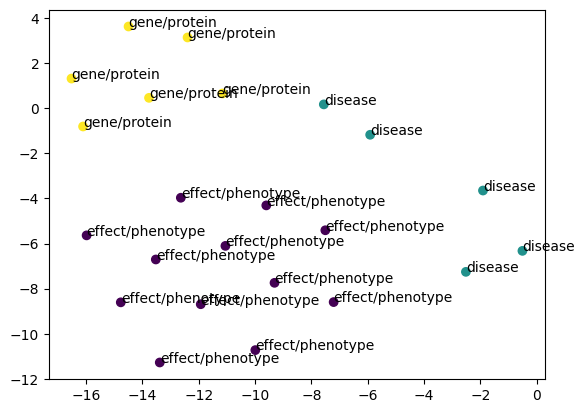

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(n_components=2, random_state=42, perplexity=15) # trial and error, 15 seems to be the cut off
# Get the embeddings and labels
embeddings = np.array([node.embedding for node in index_nodes])

reduced_embeddings = tsne.fit_transform(embeddings)
labels = [node.metadata['node_type'] for node in index_nodes]
# Convert labels to numerical values for coloring
label_to_num = {label: idx for idx, label in enumerate(set(labels))}
numeric_labels = [label_to_num[label] for label in labels]

reduced_embeddings = np.array(reduced_embeddings)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=numeric_labels, cmap='viridis')
for i, txt in enumerate(labels):
    plt.annotate(txt, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.show()


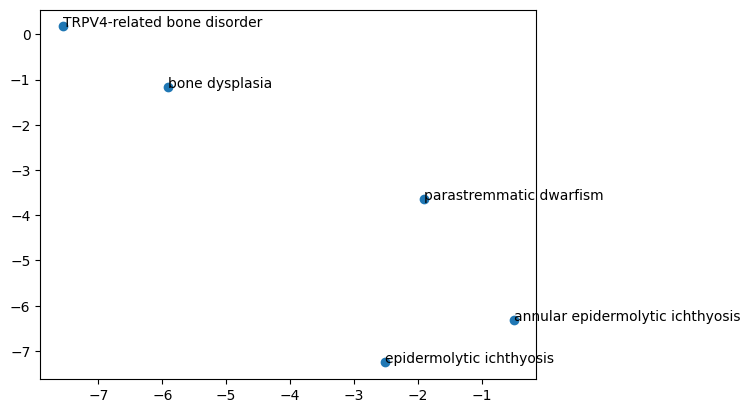

In [ ]:
# plot the embeddings according to the "node_type" = ' disease' from the "reduced_embeddings" variable
disease_embeddings = []
disease_labels = []
for i, node in enumerate(index_nodes):
    if node.metadata['node_type'] == 'disease':
        disease_embeddings.append(reduced_embeddings[i])
        disease_labels.append(node.metadata['node_name'])

#plot the embeddings
disease_embeddings = np.array(disease_embeddings)
plt.scatter(disease_embeddings[:, 0], disease_embeddings[:, 1])
for i, txt in enumerate(disease_labels):
    plt.annotate(txt, (disease_embeddings[i, 0], disease_embeddings[i, 1]))
plt.show()


### Semantic similarity VS metric similarity

semantic similarity:
1. genenerate embeddings from the 'node_name', these embeddings should capture relationships among the terms grouping similar closer together.
2. calculate pairwise cosine similarity/Eucleidian distance
    - (both methods agree on the most similar pair, which corresponds to the same pair in the graph)

?? should I apply dimensionality reduction

In [181]:
#extract all `node_names` from the `index_nodes` variable for the nodes with the `node_type` = 'disease'
disease_names = []
for node in index_nodes:
    if node.metadata['node_type'] == 'disease':
        disease_names.append(node.metadata['node_name'])

disease_names

['parastremmatic dwarfism',
 'bone dysplasia',
 'TRPV4-related bone disorder',
 'annular epidermolytic ichthyosis',
 'epidermolytic ichthyosis']

In [220]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Load a pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Replace with a biomedical model if needed

# Compute embeddings for node names
node_embeddings = model.encode(disease_names)

similarity = cosine_similarity(node_embeddings, node_embeddings)
np.fill_diagonal(similarity, 0)
max_sim = np.max(similarity)
max_idx = np.unravel_index(np.argmax(similarity), similarity.shape)
print(f"Max cosine similarity:", max_sim, (disease_names[max_idx[0]], disease_names[max_idx[1]]))

# Compute euclidean distances avoiding self-comparisons
distance = euclidean_distances(node_embeddings, node_embeddings)
np.fill_diagonal(distance, np.inf)
min_dist = np.min(distance)
min_idx = np.unravel_index(np.argmin(distance), distance.shape)
print(f"Min euclidean distance:", min_dist, (disease_names[min_idx[0]], disease_names[min_idx[1]]))

Max cosine similarity: 0.93267953 ('annular epidermolytic ichthyosis', 'epidermolytic ichthyosis')
Min euclidean distance: 0.36693457 ('annular epidermolytic ichthyosis', 'epidermolytic ichthyosis')


embeddings from the index:

In [272]:
similarity = cosine_similarity(disease_embeddings, disease_embeddings) #direct from the dimensionality reduction
np.fill_diagonal(similarity, 0)
max_sim = np.max(similarity)
max_idx = np.unravel_index(np.argmax(similarity), similarity.shape)
print(f"Max cosine similarity:", max_sim, (disease_labels[max_idx[0]], disease_labels[max_idx[1]]))

# Compute euclidean distances avoiding self-comparisons
distance = euclidean_distances(disease_embeddings, disease_embeddings)
np.fill_diagonal(distance, np.inf)
min_dist = distance.min()
min_idx = np.unravel_index(np.argmin(distance), distance.shape)
print(f"Min euclidean distance:", min_dist, (disease_labels[min_idx[0]], disease_labels[min_idx[1]]))


Max cosine similarity: 0.98910624 ('parastremmatic dwarfism', 'epidermolytic ichthyosis')
Min euclidean distance: 2.1278055 ('bone dysplasia', 'TRPV4-related bone disorder')


comparison of both:
-   between the distance from the 'node_name' and the distance from the index
- the distance value for the same pair should be similar: large distance for pairs distant in the index and in the 'node_name'